![atlas](atlas4.png)
# WESCHAR = Mineral Kinsey (DEV)
A fire atlas is a configuration convention for geospatial assets related to community fire planning and response together with a configuration for ways to instantiate, edit, and manage those assets.

A stewardship atlas is a data set, a confuration for storing, processing, and sharing that data set, and a set of implementions to do so.

In [1]:
# Boring Imports
import sys, os, subprocess, time, json, string, datetime, random, math
import geojson
import h3
sys.path.insert(0, "/root/atlas_dev/python")

# our Imports|
import json_config
import dataswale_geojson
import dataswale_geojson as dataswale
import deltas_geojson as deltas
import versioning
import vector_inlets
import raster_inlets
import outlets
import atlas
import utils
import eddies


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Use an existing swale and config:
# Create a new atlas from GeoJSON

In [2]:
#c = json.load(open("/root/swales/scvfd/staging/atlas_config.json"))

gj = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
          "name": "mineralkinsey", 
          "versioned_outlets": ["webmap"],            
          "admin_emails": ["gateless@gmail.com"],
          "base_url": "https://internal.fireatlas.org/mineralkinsey/",
          "logo": "https://internal.fireatlas.org/mineralkinsey/local/scs-smallgrass1.png"},
      "geometry": {
        "coordinates": [ utils.bbox_to_polygon({
            "south": 40.18,
            "north": 40.21,
            "west": -123.95,
            "east": -123.9
            
        })],
        "type": "Polygon"
      }}]}

layers = json.load(open("../configuration/MineralKinsey_layers.json"))
assets = json.load(open("../configuration/MineralKinsey_assets.json"))

# hack in a layer config change here
{l['name']:l for l in layers}['burns_index']['fill_opacity'] = ['get', 'haul_normalized']
#{l['name']:l for l in layers}['burns_index']['fill_opacity'] = 0.1

c = atlas.create(feature_collection=gj, layers=layers, assets=assets)

#{l['name']:l for l in c['dataswale']['layers']}['burns_index']

Updating password for user internal
Updating password for user admin
Updating password for user admin
Updating password for user internal
Updating password for user admin
Updating password for user admin
Updating password for user admin
Updating password for user internal
Updating password for user admin
Updating password for user admin
Updating password for user admin
2025-12-03 05:34:48,845 - atlas - INFO - Storing initial feature collection in {p /'layers' / 'regions'}...
2025-12-03 05:34:48,846 - atlas - INFO - built a config for mineralkinsey.


# Generate Atlas from Scratch

### Elevation and Hillshade rasters and vectors

In [ ]:
# Lidar hillshade
raster_inlets.local_raster(config=c, name="local_hillshade", delta_queue=deltas)
dataswale_geojson.refresh_raster_layer(c, 'lidar_basemap', deltas.apply_deltas)

# Still need DEM for contours - make `elevation` layer, then eddy maps:
# * derived_hillshade: elevation -> basemap 
# * gdal_contours: elevation -> contours
raster_inlets.url_raster(config=c, name="dem", delta_queue=deltas)
dataswale_geojson.refresh_raster_layer(c, 'elevation', deltas.apply_deltas)

dataswale_geojson.eddy(c, 'gdal_contours')

dataswale_geojson.eddy(c, 'derived_hillshade')

### Core vector layers

In [ ]:
# vector_inlets.overture_duckdb(config=c, name="public_roads", delta_queue=deltas)
atlas.materialize(materializers, c, 'public_roads')
dataswale_geojson.refresh_vector_layer(c, 'roads', delta_queue_builder=deltas.apply_deltas_overwrite)

In [ ]:
# vector_inlets.local_ogr(config=c, name="public_creeks", delta_queue=deltas)
atlas.materialize(materializers, c, 'public_creeks')

dataswale_geojson.refresh_vector_layer(c, 'creeks', delta_queue_builder=deltas.apply_deltas_overwrite)

In [ ]:
# vector_inlets.local_ogr(config=c, name="local_milemarkers", delta_queue=deltas)
atlas.materialize(materializers, c, 'local_burns')

dataswale_geojson.refresh_vector_layer(c, 'burns', deltas.apply_deltas)

### Buildings, Parcels, and Addresses

In [ ]:
vector_inlets.overture_duckdb(config=c, name="public_buildings", delta_queue=deltas)

dataswale_geojson.refresh_vector_layer(c, 'buildings', delta_queue_builder=deltas.apply_deltas_overwrite)

#### First load parcel layer from OpenAddresses

In [ ]:
vector_inlets.local_ogr(config=c, name="oa_parcels", delta_queue=deltas)

dataswale_geojson.refresh_vector_layer(c, 'parcels', deltas.apply_deltas_overwrite)

#### Then get addresses from Oveture - as a Delta to annotate parcels

In [ ]:
vector_inlets.overture_duckdb(config=c, name="public_addresses", delta_queue=deltas)

eddies.delta_annotate_spatial_duckdb(c, "parcels", "public_addresses__20250703_161745__create")

# No need to run this since the above annoation updates the layer
dataswale_geojson.refresh_vector_layer(c, 'parcels', deltas.apply_deltas)

#### Now use parcel layer as annotation for Buildings

In [ ]:
eddies.delta_annotate_spatial_duckdb(c, "buildings", "parcels", anno_type="layers")

### POI etc

In [ ]:
atlas.materialize(c, 'public_poi')

dataswale_geojson.refresh_vector_layer(c, 'natural')

vector_inlets.local_ogr(config=c, name="local_ponds", delta_queue=deltas)

dataswale_geojson.refresh_vector_layer(c, 'ponds', deltas.apply_deltas)

vector_inlets.local_ogr(config=c, name="local_hydrants", delta_queue=deltas)

dataswale_geojson.refresh_vector_layer(c, 'hydrants', deltas.apply_deltas)

vector_inlets.local_ogr(config=c, name="local_creeks", delta_queue=deltas)

dataswale_geojson.refresh_vector_layer(c, 'creeks', deltas.apply_deltas)

vector_inlets.local_ogr(config=c, name="local_helilandings", delta_queue=deltas)

dataswale_geojson.refresh_vector_layer(c, 'helilandings', deltas.apply_deltas)

eddies.h3_cells(c, 'burns_h3')

dataswale_geojson.refresh_document_layer(c, 'documents')

### outlets

In [14]:
outlets.outlet_html(c, 'html')

2025-12-03 10:43:52,315 - outlets - INFO - Generated Internal interfaces: [{'type': 'outlet', 'name': 'webmap', 'in_layers': ['basemap', 'parcels', 'contours', 'roads', 'creeks', 'buildings', 'natural', 'burns', 'burns_index', 'creeks_index', 'roads_index'], 'config_def': 'webmap', 'access': ['internal', 'admin'], 'config': {'asset_type': 'outlet', 'name': 'webmap', 'fetch_type': 'webmap', 'interaction': 'interface', 'attribution': {'url': 'https://portal.opentopography.org/api/terms', 'description': "Open Topography's Global DEM", 'license': 'https://portal.opentopography.org/api/terms', 'citation': 'https://portal.opentopography.org/api/terms'}, 'type': 'outlet', 'in_layers': ['basemap', 'parcels', 'contours', 'roads', 'creeks', 'buildings', 'natural', 'burns', 'burns_index', 'creeks_index', 'roads_index'], 'config_def': 'webmap', 'access': ['internal', 'admin']}}, {'type': 'outlet', 'name': 'runbook', 'in_layers': ['basemap', 'parcels', 'contours', 'roads', 'creeks', 'buildings', 'n

2025-12-03 10:43:52,390 - outlets - INFO - Making Console for ADMINISTRATION...
2025-12-03 10:43:52,393 - outlets - INFO - Making Console for INTERNAL...
2025-12-03 10:43:52,395 - outlets - INFO - Making Console for PUBLIC...


PosixPath('/root/swales/mineralkinsey/staging/outlets/html')

In [ ]:
outlets.outlet_webmap(c, 'webmap')


In [ ]:
c['dataswale']['layers']

In [ ]:
outlets.outlet_webmap_edit(c, 'webedit')

In [ ]:
c['base_url']

In [ ]:
eddies.h3_cells(c, 'burns', 'burns')

# Wesnoth

## H3

``` 
dataswale.clear_vector_layer(c, 'burns')
```
### Model Layers
* burns: homogeneous treatment areas
* creeks: water sources
* roads: vehicle access
* sites: processing sites (kilns/piles)

### Model Rules
* each site will have a distance to water and a distnace to roads
* each fuel will have a drag distance to closest site
* 

### Build index layers for treatments and features

In [3]:
$ get layers with index hexes as features
burns_index = dataswale.layer_as_featurecollection(c, 'burns_index')
creeks_index = dataswale.layer_as_featurecollection(c, 'creeks_index')
roads_index = dataswale.layer_as_featurecollection(c, 'roads_index')

print(f"Loaded H3 Index layers: burns: {len(burns_index['features'])} " +
      f" creeks: {len(creeks_index['features'])} " +
      f"roads: {len(roads_index['features'])} ")
                                           

Loaded H3 Index layers: burns: 110  creeks: 1270 roads: 492 


In [4]:
burn_cells = [b["properties"]["h3_index"]
              for b in burns_index['features']]
creek_cells = [b["properties"]["h3_index"]
              for b in creeks_index['features']]
road_cells = [b["properties"]["h3_index"]
              for b in roads_index['features']]

In [5]:
def match_resolution_at_centers(cell1, cell2):
    target, c,d = None, None, None
    if cell1['properties']['h3_resolution'] < cell2['properties']['h3_resolution']:
        target = cell2['properties']['h3_resolution']
        c = cell1
        d = cell2
    elif cell1['properties']['h3_resolution'] > cell2['properties']['h3_resolution']:
        target = cell1['properties']['h3_resolution']
        c = cell2
        d = cell1
    else:
        print("Already EQUAL")
        target = cell1['properties']['h3_resolution']
        c = cell1
        d = cell2
        
    while c['properties']['h3_resolution'] < target:
        c['properties']['h3_resolution'] += 1
        c['properties']['h3_index'] = h3.cell_to_center_child(c['properties']['h3_index'])
    return cell1, cell2
    


#results = []

def get_treatments_for_layer(c, treatments, burns_index):
    for burn in burns_index['features']:
        burn['properties']['treatments'] = cell_yield(c, treatments, burn)
    return burns_index

def get_fuels_for_layer(c, burns_index):
    for burn in burns_index['features']:
        burn['properties']['fuel_mass'] = 1.0
    return burns_index

def get_cell_path_distances(c, burns_index, creeks_index, distance_name):
    """
    For each H3 cell in `from_layer`, get the min H3 path to everything in `to_layer`
    at the minimum common resolution.
    """
    layer_dict = {l['name']:l for l in c['dataswale']['layers']}
    
    results = []
    for burn in burns_index['features']:
        distances = []
        burn_h3 = burn['properties']['h3_index']
        burn_h3_res = burn['properties']['h3_resolution']
        for creek in creeks_index['features']:
            creek_h3 = creek['properties']['h3_index']
            #burn_h3_center = h3.cell_to_center_child(burn_h3)
            #old_burn = burn.copy()
            burn, creek = match_resolution_at_centers(burn, creek)
            print(f"{burn_h3} [{burn_h3_res}] -> " +
                  f"{burn['properties']['h3_index']} [{burn['properties']['h3_resolution']}] -> " +
                  f"{creek_h3} [{burn['properties']['h3_resolution']}]")
            try:
                d = h3.grid_distance(burn['properties']['h3_index'], creek_h3)
                distances.append(d)
            except Exception as e:
                # h3.grid_distance raises if resolution mismatch or invalid path
                print(f"Problem {e}: {burn['properties']['h3_resolution']} -> " +
                      f"{creek['properties']['h3_resolution']}")
                continue
        if distances:
            min_d = min(distances)
        else:
            min_d = None
        burn['properties'][distance_name] = min_d
        #burn['properties']['name'] = str(min_d)
        results.append({
            #"burn_id": burn_id,
            "burn_h3": burn_h3,
            "min_h3_steps": min_d
    })
    return burns_index

def cell_yield(c, treatments, burn):
    tm = {}
    water_distance = burn['properties']['creek_distance']
    drag_distance = burn['properties']['roads_distance']
    
    for tn, tc in treatments.items():
        # staff hours to process one acre
        processing_rate = tc['production_rate'] \
            + water_distance * tc['water_distance_cost'] \
            + drag_distance * tc['drag_distance_cost']
        # total biomass extracted
        processed =  burn['properties']['fuel_mass'] * tc['biomass_rate']
        
        # total biochar generated
        biochar = tc['biochar_rate'] * processed
        
        # cost per staff hour
        cost_rate = tc['cost_rate'] / 8.0
        
        # wtf are units here?
        risk_reduced =  burn['properties']['fuel_mass'] * tc['risk_reduction_rate']
        
        # cell calcs
        
        fuel_price = 0.001
        biochar_price = 0.01
        
        tm[tn] = {
            'budget_cost': processing_rate * cost_rate,
            'biomass_extracted' : processed,
            'biochar_extracted' : biochar,
            'air_pollution' : tc['air_pollution'] * processed,
            'risk_reduced': risk_reduced,
            'biomass_sale': fuel_price * processed,
            'biochar_sale': biochar_price * biochar
        }
    return tm


def old_cell_yield(c, treatments, burn):
    tm = {}
    water_distance = burn['properties']['creek_distance']
    drag_distance = burn['properties']['roads_distance']
    
    for tn, tc in treatments.items():
        # staff hours to process one acre
        processing_rate = tc['production_rate'] \
            + water_distance * tc['water_distance_cost'] \
            + drag_distance * tc['drag_distance_cost']
        # total biomass extracted
        processed =  burn['properties']['fuel_mass'] * tc['biomass_rate']
        
        # total biochar generated
        biochar = tc['biochar_rate'] * processed
        
        # cost per staff hour
        cost_rate = tc['cost_rate'] / 8.0
        
        # wtf are units here?
        risk_reduced =  burn['properties']['fuel_mass'] * tc['risk_reduction_rate']
        
        # cell calcs
        
        fuel_price = 0.001
        biochar_price = 0.01
        
        tm[tn] = {
            'budget_cost': processing_rate * cost_rate,
            'biomass_extracted' : processed,
            'biochar_extracted' : biochar,
            'air_pollution' : tc['air_pollution'] * processed,
            'risk_reduced': risk_reduced,
            'biomass_sale': fuel_price * processed,
            'biochar_sale': biochar_price * biochar
        }
    return tm


def merge_distances(c, layer_index, dist1, dist2, new_distance):
    distances = {dist1:[], dist2:[], new_distance:[]}
    for feat in layer_index['features']:
        f = feat['properties']
        f[new_distance] = f[dist1] + f[dist2]
        
        distances[dist1].append(f[dist1])
        distances[dist2].append(f[dist2])
        distances[new_distance].append(f[new_distance])
        
    maxes = {
        dist1: max(distances[dist1]),
        dist2 : max(distances[dist2]),
        new_distance : max(distances[new_distance])}
    
    for feat in layer_index['features']:
        for d in [dist1, dist2, new_distance]:
             feat['properties'][f"{d}_normalized"] = \
                float(feat['properties'][d])/float(maxes[d])
        feat['properties']['name'] = ""
            #f"{feat['properties']['creek_distance_normalized']:.2f} {feat['properties']['haul_normalized']:.2f}" 
    #max_dist = max(distances)
    
    return layer_index


In [6]:
treatments = [
  {
    "name": "conservation burn",
    "summary": "A carefully planned, agency-supervised prescribed burn applied to reduce surface and ladder fuels across a landscape window.",
    "production_rate": 2.4,
    "risk_reduction_rate": 0.90,
    "biomass_rate": 0.90,
    "biochar_rate": 0.03,
    "drag_distance_cost": 0.005,
    "water_distance_cost": 0.05,
    "air_pollution": 8,
    "cost_rate": 3000
  },
  {
    "name": "ring of fire kiln",
    "summary": "A small-to-medium stationary biochar kiln (air-curtain / ring) where collected biomass is burned/converted to char near a processing pit.",
    "production_rate": 16,
    "risk_reduction_rate": 0.80,
    "biomass_rate": 0.80,
    "biochar_rate": 0.10,
    "drag_distance_cost": 0.05,
    "water_distance_cost": 0.02,
    "air_pollution": 4,
    "cost_rate": 600
  },
  {
    "name": "trailer kiln",
    "summary": "A mobile (trailer-mounted) pyrolysis/char unit brought to the site that processes chipped/collected feedstock into biochar and energy co-products.",
    "production_rate": 8,
    "risk_reduction_rate": 0.90,
    "biomass_rate": 0.90,
    "biochar_rate": 0.30,
    "drag_distance_cost": 0.03,
    "water_distance_cost": 0.01,
    "air_pollution": 2,
    "cost_rate": 1000
  },
  {
    "name": "chop and leave",
    "summary": "Cutting or mastication of understory/ladders and leaving the woody material scattered as mulch (no extraction).",
    "production_rate": 20,
    "risk_reduction_rate": 0.50,
    "biomass_rate": 0.01,
    "biochar_rate": 0.0,
    "drag_distance_cost": 0.0001,
    "water_distance_cost": 0.005,
    "air_pollution": 1,
    "cost_rate": 300
  }
]
treatments_dict = {v['name']:v for v in treatments}

In [7]:
treatments_url = 'https://raw.githubusercontent.com/scotfree/fuelscape/refs/heads/main/treatments.json'
treatments = json.loads(urllib.request.urlopen(treatments_url).read())

#treatments[0].keys()

## Build new logistics models
### Add new distance(s) to h3 cell layer

In [8]:
sites_index = get_cell_path_distances(c, sites_index, roads_index, 'roads_distance')
sites_index = get_cell_path_distances(c, sites_index, creeks_index, 'creeks_distance')

Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c8599fff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c8591fff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c85abfff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c8598fff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c859afff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c8436fff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c858cfff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c859dfff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c859cfff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c8581fff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c859efff [11]
Already EQUAL
8b28062ca098fff [11] -> 8b28062ca098fff [11] -> 8b28062c84a6fff [11]
Alre

Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cadabfff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cac23fff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cac2bfff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cac2efff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cac32fff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cac46fff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cad95fff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cad81fff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cac31fff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cad83fff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cac73fff [11]
Already EQUAL
8b28062ca720fff [11] -> 8b28062ca720fff [11] -> 8b28062cac72fff [11]
Alre

8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9aa9fff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a18fff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a45fff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a54fff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a6cfff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a6efff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a48fff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a49fff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b2802964d12fff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a6dfff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b28062d9a4bfff [11]
Already EQUAL
8b28062ca730fff [11] -> 8b28062ca730fff [11] -> 8b2802964d36fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062c8692fff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062c8410fff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062cb511fff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062caa4afff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062c84e6fff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062c8796fff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062cab4efff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062cb51bfff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062cb408fff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062cbd95fff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062c84c4fff [11]
Already EQUAL
8b28062ca46afff [11] -> 8b28062ca46afff [11] -> 8b28062cbda6fff [11]
Alre

8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9844fff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9169fff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9b98fff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9841fff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9bb1fff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9b9afff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9b99fff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9b8efff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9b8afff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9b8cfff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d9b98fff [11]
Already EQUAL
8b28062ca443fff [11] -> 8b28062ca443fff [11] -> 8b28062d914dfff [11]
Already EQUAL
8b28

8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28062ca29afff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28062ca668fff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28062ca656fff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28062ca654fff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28062ca646fff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28029649a8fff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28029649adfff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28029649aefff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca441fff [11] -> 8b28062ca441fff [11] -> 8b2802964980fff [11]
Already EQUAL
8b28

8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca553fff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca429fff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca55efff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca404fff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca432fff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca583fff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca405fff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca58efff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca59afff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca51bfff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca580fff [11]
Already EQUAL
8b28062ca453fff [11] -> 8b28062ca453fff [11] -> 8b28062ca59cfff [11]
Already EQUAL
8b28

8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062dd271fff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062d9861fff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062dd20bfff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062d986cfff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062d9868fff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062d9968fff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062dd340fff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062dd264fff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062dd272fff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062d994afff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062cad90fff [11]
Already EQUAL
8b28062ca7a0fff [11] -> 8b28062ca7a0fff [11] -> 8b28062dd35dfff [11]
Already EQUAL
8b28

Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b28062cb4e3fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b28029648a4fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b2802964861fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b28062cb4e1fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b2802964814fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b28062cb4f3fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b2802964871fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b2802964828fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b280296481dfff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b2802964876fff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b28062cac6afff [11]
Already EQUAL
8b28062ca4e8fff [11] -> 8b28062ca4e8fff [11] -> 8b28062cac44fff [11]
Alre

Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062dd20bfff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062d986cfff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062d9868fff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062d9968fff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062dd340fff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062dd264fff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062dd272fff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062d994afff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062cad90fff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062dd35dfff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062d9865fff [11]
Already EQUAL
8b28062ca4e0fff [11] -> 8b28062ca4e0fff [11] -> 8b28062dd2c9fff [11]
Alre

Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cac46fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cad95fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cad81fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cac31fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cad83fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cac73fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cac72fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cad80fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cac14fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cac28fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cac76fff [11]
Already EQUAL
8b28062ca4c0fff [11] -> 8b28062ca4c0fff [11] -> 8b28062cada4fff [11]
Alre

8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca681fff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca6aefff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca60afff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca61bfff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca6a8fff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca682fff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca6a9fff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca609fff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca619fff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca695fff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca685fff [11]
Already EQUAL
8b28062ca4c6fff [11] -> 8b28062ca4c6fff [11] -> 8b28062ca60bfff [11]
Already EQUAL
8b28

8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca61cfff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca621fff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca618fff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca62efff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca619fff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca619fff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca65bfff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca6ecfff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28029649a6fff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca652fff [11]
Already EQUAL
8b28062ca4f3fff [11] -> 8b28062ca4f3fff [11] -> 8b28062ca65afff [11]
Already EQUAL
8b28

Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062dd368fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062dd2e1fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062dd254fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062d9969fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062d994dfff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062dd275fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062d996bfff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062dd343fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062cad80fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062dd345fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062ca592fff [11]
Already EQUAL
8b28062ca4a9fff [11] -> 8b28062ca4a9fff [11] -> 8b28062dd348fff [11]
Alre

8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac06fff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac02fff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac22fff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac15fff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cadabfff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac23fff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac2bfff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac2efff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac32fff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cac46fff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cad95fff [11]
Already EQUAL
8b28062ca4ebfff [11] -> 8b28062ca4ebfff [11] -> 8b28062cad81fff [11]
Already EQUAL
8b28

8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cac2efff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cac32fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cac46fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cad95fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cad81fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cac31fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cad83fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cac73fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cac72fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cad80fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cac14fff [11]
Already EQUAL
8b28062d9a70fff [11] -> 8b28062d9a70fff [11] -> 8b28062cac28fff [11]
Already EQUAL
8b28

8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28062ca62efff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28062ca619fff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28062ca619fff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28062ca65bfff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28062ca6ecfff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28029649a6fff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28062ca652fff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28062ca65afff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28029649a0fff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28029649a4fff [11]
Already EQUAL
8b28062ca700fff [11] -> 8b28062ca700fff [11] -> 8b28062ca6edfff [11]
Already EQUAL
8b28

8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b28062ca370fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b28062ca362fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b28062cb4dafff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b2802964b28fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b28062cb4d3fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b28062cb489fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b28062cb4d6fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b2802964b2dfff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b28062cb4d0fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b2802964b34fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b2802964819fff [11]
Already EQUAL
8b28062d9b10fff [11] -> 8b28062d9b10fff [11] -> 8b2802964b26fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062c84acfff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062cbcb4fff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062cb4e1fff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062c8413fff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062c84c8fff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062cb404fff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062c841efff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062cbc86fff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062cb510fff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062cbd9afff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062ca375fff [11]
Already EQUAL
8b28062d9b20fff [11] -> 8b28062d9b20fff [11] -> 8b28062ca365fff [11]
Alre

Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cbcb1fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cb40bfff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cb532fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cab49fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062c8696fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cb4e5fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062c8418fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cbcb0fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cbc91fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062c84adfff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cbdb0fff [11]
Already EQUAL
8b28062d9b08fff [11] -> 8b28062d9b08fff [11] -> 8b28062cbdb3fff [11]
Alre

Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a19fff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9aa8fff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a1afff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a1dfff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a55fff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a6efff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a84fff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a09fff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a0afff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9aaefff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9ab6fff [11]
Already EQUAL
8b28062d9b00fff [11] -> 8b28062d9b00fff [11] -> 8b28062d9a46fff [11]
Alre

Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a46fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9af4fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a40fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9ab1fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a85fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9aa9fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a18fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a45fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a54fff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a6cfff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a6efff [11]
Already EQUAL
8b28062d9ba8fff [11] -> 8b28062d9ba8fff [11] -> 8b28062d9a48fff [11]
Alre

8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b28062ca618fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b28062ca656fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b28062ca6f4fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b280296499dfff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b2802964999fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b2802964983fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b280296498afff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b28029648a4fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b2802964996fff [11]
Already EQUAL
8b28062d9b50fff [11] -> 8b28062d9b50fff [11] -> 8b2802964995fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9aa9fff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a18fff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a45fff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a54fff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a6cfff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a6efff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a48fff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a49fff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b2802964d12fff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a6dfff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b28062d9a4bfff [11]
Already EQUAL
8b28062ca725fff [11] -> 8b28062ca725fff [11] -> 8b2802964d36fff [11]
Alre

8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28062ca646fff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28029649a8fff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28029649adfff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28029649aefff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b2802964980fff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b2802964984fff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28062ca60bfff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28062ca609fff [11]
Already EQUAL
8b28062ca721fff [11] -> 8b28062ca721fff [11] -> 8b28062ca672fff [11]
Already EQUAL
8b28

8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca603fff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca756fff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca61cfff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca621fff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca618fff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca62efff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca619fff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca619fff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca65bfff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28062ca6ecfff [11]
Already EQUAL
8b28062ca728fff [11] -> 8b28062ca728fff [11] -> 8b28029649a6fff [11]
Already EQUAL
8b28

8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062ca51bfff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062ca519fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062dd2c5fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062ca4b6fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062d9959fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062dd273fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062dd2e3fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062dd2cdfff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062dd209fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062dd270fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062cad82fff [11]
Already EQUAL
8b28062ca498fff [11] -> 8b28062ca498fff [11] -> 8b28062dd2e0fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062ca892fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac64fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac6cfff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac65fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac46fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac45fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac66fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac63fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac44fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac46fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac62fff [11]
Already EQUAL
8b28062ca480fff [11] -> 8b28062ca480fff [11] -> 8b28062cac44fff [11]
Alre

8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b280296481efff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b2802964805fff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b2802964868fff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b2802964874fff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b28062cb4f1fff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b280296482efff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b2802964816fff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b2802964870fff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b28062cb48bfff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b280296482afff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b280296482dfff [11]
Already EQUAL
8b28062ca488fff [11] -> 8b28062ca488fff [11] -> 8b2802964815fff [11]
Already EQUAL
8b28

8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062c84c1fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062c84e2fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062c84c9fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062cab48fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062cb401fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062cb514fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062caa6cfff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062c84acfff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062cbcb4fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062cb4e1fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062c8413fff [11]
Already EQUAL
8b28062caa90fff [11] -> 8b28062caa90fff [11] -> 8b28062c84c8fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062c84c4fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062cbda6fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062cb51efff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062cab65fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062cab61fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062c84f1fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062caa48fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062cbdb5fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062cb518fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062c8433fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062caa68fff [11]
Already EQUAL
8b28062ca040fff [11] -> 8b28062ca040fff [11] -> 8b28062cbcb1fff [11]
Alre

8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9b9afff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9842fff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9ba6fff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9b9cfff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9b86fff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9868fff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9840fff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9858fff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9b83fff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d985cfff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d9b82fff [11]
Already EQUAL
8b28062ca148fff [11] -> 8b28062ca148fff [11] -> 8b28062d986afff [11]
Already EQUAL
8b28

8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b280296499dfff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b2802964999fff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b2802964983fff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b280296498afff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b28029648a4fff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b2802964996fff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b2802964995fff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b2802964994fff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b28062ca6cbfff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b28062ca690fff [11]
Already EQUAL
8b28062ca058fff [11] -> 8b28062ca058fff [11] -> 8b28062d9a6efff [11]
Already EQUAL
8b28

8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d9bb1fff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d9b9afff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d9b99fff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d9b8efff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d9b8afff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d9b8cfff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d9b98fff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d914dfff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d914cfff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d9ab6fff [11]
Already EQUAL
8b28062ca0e8fff [11] -> 8b28062ca0e8fff [11] -> 8b28062d914cfff [11]
Already EQUAL
8b28062d9b88fff [11] -> 8b28062d9b88fff [11] -> 8b28062c8599fff [11]
Already EQUAL
8b28

8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a45fff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a54fff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a6cfff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a6efff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a48fff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a49fff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b2802964d12fff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a6dfff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a4bfff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b2802964d36fff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b28062d9a69fff [11]
Already EQUAL
8b28062d9a30fff [11] -> 8b28062d9a30fff [11] -> 8b2802964d16fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b28062ca680fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b28062ca618fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b28062ca656fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b28062ca6f4fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b280296499dfff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b2802964999fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b2802964983fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b280296498afff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b28029648a4fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062d9b5efff [11] -> 8b28062d9b5efff [11] -> 8b2802964996fff [11]
Alre

Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca640fff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca645fff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca66afff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca29bfff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca299fff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca669fff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca655fff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca29afff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca668fff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca656fff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca654fff [11]
Already EQUAL
8b28062d9b4efff [11] -> 8b28062d9b4efff [11] -> 8b28062ca646fff [11]
Alre

8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062d9969fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062d994dfff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062dd275fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062d996bfff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062dd343fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062cad80fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062dd345fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062ca592fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062dd348fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062dd266fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062d9948fff [11]
Already EQUAL
8b28062d9b71fff [11] -> 8b28062d9b71fff [11] -> 8b28062cadb1fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062cac72fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062cad80fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062cac14fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062cac28fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062cac76fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062cada4fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062cada6fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062dda59fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062dda42fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062dda5cfff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062dda58fff [11]
Already EQUAL
8b28062d9b75fff [11] -> 8b28062d9b75fff [11] -> 8b28062dda5afff [11]
Alre

Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062dd348fff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062dd266fff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062d9948fff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062cadb1fff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062d996cfff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062dd34afff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062dd2e5fff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062d9965fff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062d9961fff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062cad86fff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062dd2ccfff [11]
Already EQUAL
8b28062d9b66fff [11] -> 8b28062d9b66fff [11] -> 8b28062cad93fff [11]
Alre

Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cad82fff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cad8cfff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac06fff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac02fff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac22fff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac15fff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cadabfff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac23fff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac2bfff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac2efff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac32fff [11]
Already EQUAL
8b28062ca4d8fff [11] -> 8b28062ca4d8fff [11] -> 8b28062cac46fff [11]
Alre

8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b280296482afff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b280296482dfff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b2802964815fff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b2802964801fff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b280296480afff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b2802964863fff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b2802964811fff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b280296480efff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b2802964869fff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b2802964818fff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b28062cb489fff [11]
Already EQUAL
8b28062ca4dbfff [11] -> 8b28062ca4dbfff [11] -> 8b280296495afff [11]
Already EQUAL
8b28

8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b28062cb4e3fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b28029648a4fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b2802964861fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b28062cb4e1fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b2802964814fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b28062cb4f3fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b2802964871fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b2802964828fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b280296481dfff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b2802964876fff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b28062cac6afff [11]
Already EQUAL
8b28062ca4cefff [11] -> 8b28062ca4cefff [11] -> 8b28062cac44fff [11]
Already EQUAL
8b28

8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062dda51fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062ca51bfff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062ca519fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062dd2c5fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062ca4b6fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062d9959fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062dd273fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062dd2e3fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062dd2cdfff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062dd209fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062dd270fff [11]
Already EQUAL
8b28062ca4cafff [11] -> 8b28062ca4cafff [11] -> 8b28062cad82fff [11]
Already EQUAL
8b28

8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062ca269fff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062cbd93fff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062c8692fff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062cbc9efff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062cab41fff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062cb40efff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062cab45fff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062c84c5fff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062cab6efff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062caa59fff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062cb426fff [11]
Already EQUAL
8b28062ca4c3fff [11] -> 8b28062ca4c3fff [11] -> 8b28062cbd9efff [11]
Already EQUAL
8b28

Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062c84c5fff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062cab6efff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062caa59fff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062cb426fff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062cbd9efff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062cbc95fff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062c841bfff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062cb422fff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062cb405fff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062c8415fff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062c84c0fff [11]
Already EQUAL
8b28062d9a28fff [11] -> 8b28062d9a28fff [11] -> 8b28062cb536fff [11]
Alre

8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062caa75fff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062c8692fff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062c8410fff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062cb511fff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062caa4afff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062c84e6fff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062c8796fff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062cab4efff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062cb51bfff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062cb408fff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062cbd95fff [11]
Already EQUAL
8b28062ca0a8fff [11] -> 8b28062ca0a8fff [11] -> 8b28062c84c4fff [11]
Already EQUAL
8b28

8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9859fff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9ba2fff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9844fff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9169fff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9b98fff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9841fff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9bb1fff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9b9afff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9b99fff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9b8efff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9b8afff [11]
Already EQUAL
8b28062ca018fff [11] -> 8b28062ca018fff [11] -> 8b28062d9b8cfff [11]
Already EQUAL
8b28

Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b28062ca618fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b28062ca656fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b28062ca6f4fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b280296499dfff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b2802964999fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b2802964983fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b280296498afff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b28029648a4fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b2802964996fff [11]
Already EQUAL
8b28062ca0d0fff [11] -> 8b28062ca0d0fff [11] -> 8b2802964995fff [11]
Alre

8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca60bfff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca609fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca672fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca600fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca752fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca605fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca603fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca756fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca61cfff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca621fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca618fff [11]
Already EQUAL
8b28062ca41cfff [11] -> 8b28062ca41cfff [11] -> 8b28062ca62efff [11]
Already EQUAL
8b28

8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062d9a6efff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062d9a48fff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062d9a49fff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b2802964d12fff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062d9a6dfff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062d9a4bfff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b2802964d36fff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062d9a69fff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b2802964d16fff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062d9a4dfff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062dd2cefff [11]
Already EQUAL
8b28062ca41afff [11] -> 8b28062ca41afff [11] -> 8b28062dd2ccfff [11]
Already EQUAL
8b28

8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d985cfff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9b82fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d986afff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9ab6fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9846fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9859fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9ba2fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9844fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9169fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9b98fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9841fff [11]
Already EQUAL
8b28062ca418fff [11] -> 8b28062ca418fff [11] -> 8b28062d9bb1fff [11]
Already EQUAL
8b28

8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28062ca29afff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28062ca668fff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28062ca656fff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28062ca654fff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28062ca646fff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28029649a8fff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28029649adfff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28029649aefff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b2802964982fff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b28029649a3fff [11]
Already EQUAL
8b28062ca41bfff [11] -> 8b28062ca41bfff [11] -> 8b2802964980fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062dd340fff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062dd264fff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062dd272fff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062d994afff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062cad90fff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062dd35dfff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062d9865fff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062dd2c9fff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062cad84fff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062dd36afff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062dd2eafff [11]
Already EQUAL
8b28062ca330fff [11] -> 8b28062ca330fff [11] -> 8b28062d9864fff [11]
Alre

8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062cad82fff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062dd2e0fff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062dd2cbfff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062cadb0fff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062dd271fff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062d9861fff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062dd20bfff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062d986cfff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062d9868fff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062d9968fff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062dd340fff [11]
Already EQUAL
8b28062caaa0fff [11] -> 8b28062caaa0fff [11] -> 8b28062dd264fff [11]
Already EQUAL
8b28

8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cac31fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cad83fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cac73fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cac72fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cad80fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cac14fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cac28fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cac76fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cada4fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062cada6fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062dda59fff [11]
Already EQUAL
8b28062caaf0fff [11] -> 8b28062caaf0fff [11] -> 8b28062dda42fff [11]
Already EQUAL
8b28

8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b28062cb4d4fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b2802964862fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b2802964b35fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b2802964872fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b28029648a5fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b280296481efff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b2802964805fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b2802964868fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b2802964874fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b28062cb4f1fff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b280296482efff [11]
Already EQUAL
8b28062cbdb0fff [11] -> 8b28062cbdb0fff [11] -> 8b2802964816fff [11]
Already EQUAL
8b28

Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062ca365fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062ca360fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062cbd92fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062cbd90fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062ca370fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062ca362fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062cb4dafff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b2802964b28fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062cb4d3fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062cb489fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b28062cb4d6fff [11]
Already EQUAL
8b28062caab0fff [11] -> 8b28062caab0fff [11] -> 8b2802964b2dfff [11]
Alre

In [10]:
burns_index = get_fuels_for_layer(c, burns_index)
burns_index = get_cell_path_distances(c, burns_index, sites_index, 'sites_distance')

In [11]:
burns_index = get_treatments_for_layer(c, treatments_dict, burns_index)

In [12]:
burns_index[3]

{"geometry": {"coordinates": [[[-123.915066, 40.195731], [-123.914426, 40.196237], [-123.914645, 40.196886], [-123.915505, 40.197029], [-123.916146, 40.196522], [-123.915926, 40.195873]]], "type": "Polygon"}, "properties": {"Comments": null, "Description": "terrace1", "GroundFuels": 1, "UnitNum": 2, "area": 25818.134565376677, "creek_distance": 4, "creek_distance_normalized": 0.5714285714285714, "fid": 2, "fuel_mass": 1.0, "h3_cell_count": 2, "h3_index": "8b28062ca730fff", "h3_resolution": 11, "haul": 7, "haul_normalized": 0.3684210526315789, "name": "", "roads_distance": 3, "roads_distance_normalized": 0.2, "source_feature_id": 1, "treatments": {"chop and leave": {"air_pollution": 0.01, "biochar_extracted": 0.0, "biochar_sale": 0.0, "biomass_extracted": 0.01, "biomass_sale": 1e-05, "budget_cost": 750.7612499999999, "risk_reduced": 0.5}, "conservation burn": {"air_pollution": 7.2, "biochar_extracted": 0.027, "biochar_sale": 0.00027, "biomass_extracted": 0.9, "biomass_sale": 0.000900000

In [13]:
import geopandas
gdf = geopandas.GeoDataFrame.from_features(burns_index)    

measures = burns_index['features'][0]['properties']['treatments']['conservation burn'].keys()
#measures

In [15]:
tot = {}
for t in treatments_dict.keys():
    tot[t] = {}
    for m in measures:
        tot[t][m] = 0.0
        for b in burns_index['features']:
            #print(f"T: {t} M: {m}")
            tot[t][m] += b['properties']['treatments'][t][m]

In [18]:
import numpy as np
metrics = list(next(iter(tot.values())).keys())
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist() + [0]
[60*x for x in angles]

[0.0,
 53.85587406153931,
 107.71174812307862,
 161.56762218461793,
 215.42349624615724,
 269.2793703076966,
 323.13524436923586,
 0]

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def radar_chart(data):
    metrics = list(next(iter(data.values())).keys())
    treatments = data.keys()
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles = np.append(angles, angles[0])
    print(f"Met: {metrics} Angles: {angles}")
    fig, ax = plt.subplots(figsize=(12,12), subplot_kw=dict(projection='polar'))
    
    # Normalize values to 0-1 scale
    all_values = [v for values in data.values() for v in values.values()]
    max_val = max(all_values)
    maxes = {}
    for v in metrics:
        maxes[v] = max([data[t][v] for t in treatments])
    print(f"Maxes: {maxes}")
    for treatment, values in data.items():
        values_list = [values[m]/maxes[m] for m in metrics] + [values[metrics[0]]/maxes[metrics[0]]]
        print(f"T: {treatment} A: {angles} V: {values_list}")
        ax.plot(angles, values_list, 'o-', linewidth=2, label=treatment)
        #ax.fill(angles, values_list, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    plt.setp(ax.get_xticklabels(), backgroundcolor="lightgray")
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()
    plt.savefig('radar.png')

Met: ['budget_cost', 'biomass_extracted', 'biochar_extracted', 'air_pollution', 'risk_reduced', 'biomass_sale', 'biochar_sale'] Angles: [0.         0.8975979  1.7951958  2.6927937  3.5903916  4.48798951
 5.38558741 0.        ]
Maxes: {'budget_cost': 134119.5, 'biomass_extracted': 99.00000000000014, 'biochar_extracted': 29.69999999999996, 'air_pollution': 792.0000000000011, 'risk_reduced': 99.00000000000014, 'biomass_sale': 0.09899999999999988, 'biochar_sale': 0.2969999999999999}
T: conservation burn A: [0.         0.8975979  1.7951958  2.6927937  3.5903916  4.48798951
 5.38558741 0.        ] V: [0.7893986333083556, 1.0, 0.10000000000000021, 1.0, 1.0, 1.0, 0.0999999999999999, 0.7893986333083556]
T: ring of fire kiln A: [0.         0.8975979  1.7951958  2.6927937  3.5903916  4.48798951
 5.38558741 0.        ] V: [1.0, 0.8888888888888857, 0.2962962962962969, 0.44444444444444287, 0.8888888888888857, 0.8888888888888891, 0.2962962962962961, 1.0]
T: trailer kiln A: [0.         0.8975979  1.79

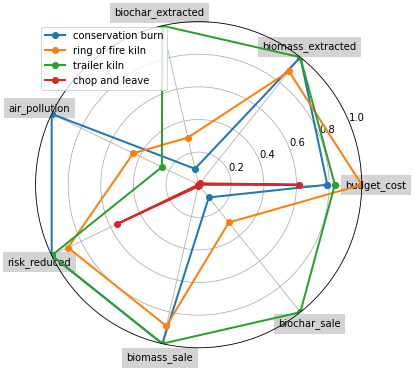

In [20]:
radar_chart(tot)

Met: ['a', 'b', 'c', 'd', 'e'] Angles: [0.         1.25663706 2.51327412 3.76991118 5.02654825 0.        ]
Maxes: {'a': 100000.5, 'b': 0.65, 'c': 0.5, 'd': 0.5, 'e': 0.5}
T: alpha A: [0.         1.25663706 2.51327412 3.76991118 5.02654825 0.        ] V: [1.0, 0.7692307692307692, 1.0, 1.0, 1.0, 1.0]
T: beta A: [0.         1.25663706 2.51327412 3.76991118 5.02654825 0.        ] V: [7.499962500187499e-06, 0.7692307692307692, 0.5, 1.0, 1.0, 7.499962500187499e-06]
T: gamma A: [0.         1.25663706 2.51327412 3.76991118 5.02654825 0.        ] V: [3.4999825000874993e-06, 1.0, 0.3, 1.0, 1.0, 3.4999825000874993e-06]


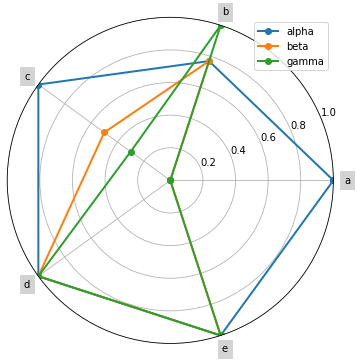

In [5]:
radar_chart(
    {"alpha" : {"a": 100000.5, "b": 0.5, "c": 0.5, "d": 0.5, "e": 0.5},
    "beta" : {"a": 0.75, "b": 0.5, "c": 0.25, "d": 0.5, "e": 0.5},
    "gamma" : {"a": 0.35, "b": 0.65, "c": 0.15, "d": 0.5, "e": 0.5}})


Met: ['budget_cost', 'biomass_extracted', 'biochar_extracted', 'air_pollution', 'risk_reduced', 'biochar_sale'] Angles: [0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776
 0.        ]
Maxes: {'budget_cost': 0.9, 'biomass_extracted': 0.8, 'biochar_extracted': 0.5, 'air_pollution': 0.5, 'risk_reduced': 0.8, 'biochar_sale': 0.2}
T: kilns A: [0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776
 0.        ] V: [1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0]
T: piles A: [0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776
 0.        ] V: [0.4444444444444445, 1.0, 0.2, 1.0, 0.8749999999999999, 0.5, 0.4444444444444445]


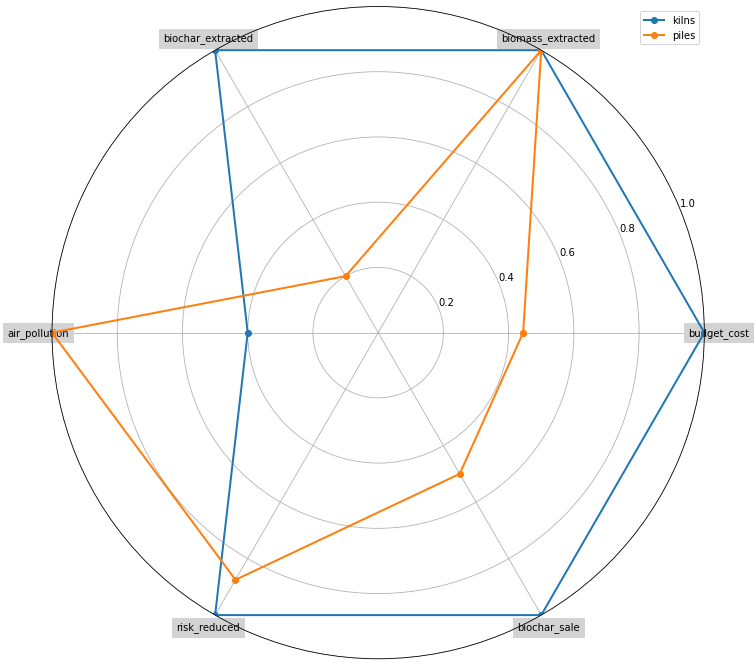

<Figure size 432x288 with 0 Axes>

In [13]:
t1={
            'budget_cost': 0.9,
            'biomass_extracted' : 0.8,
            'biochar_extracted' : 0.5,
            'air_pollution' : 0.2,
            'risk_reduced': 0.8,
            'biochar_sale': 0.2
        }
t2={
            'budget_cost': 0.4,
            'biomass_extracted' : 0.8,
            'biochar_extracted' : 0.1,
            'air_pollution' : 0.5,
            'risk_reduced': 0.7,
            'biochar_sale': 0.1
        }
radar_chart({"kilns" : t1, "piles": t2})

In [ ]:
import pandas
df = pandas.DataFrame(tot)

In [ ]:
df

In [ ]:
for title, values in tot.items():
    plt.figure()
    plt.bar(values.keys(), values.values())
    plt.title(title)
plt.show()

In [ ]:
spidey(tot['conservation burn'].keys(), tot['conservation burn'].values())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Speed', 'Strength', 'Agility', 'Stamina', 'Skill']
values = [80, 70, 90, 65, 85]

for tn,t in tot.items():
    
    spidey(t.keys(), t.values())

plt.show()

In [ ]:
gdf

### Generate new distance from old distances

In [ ]:
burns_index =  merge_distances(c, burns_index, 'roads_distance', 'creek_distance', 'haul')

In [ ]:
burns_index['features'][3]['properties']

### Save modified layer

In [ ]:
file_path = dataswale.layer_as_path(c,'burns_index')

fc = geojson.FeatureCollection(0)
fc['features'] = burns_index['features']
                                       
with open(file_path, 'w') as f:
    geojson.dump(fc, f)

In [ ]:
c['assets']['spreadsheet_export']#['in_layers'] = ['burns_index']

In [ ]:
outlets.gsheet_export(c, 'spreadsheet_export')

In [ ]:
mkc = json.load(open("/root/swales/mineralkinsey/staging/atlas_config.json"))
mkc['spreadsheets']

# Creek Detail Exploration
    

In [ ]:
creeks = dataswale.layer_as_featurecollection(c, 'creeks')

In [ ]:
import geopandas
gpd = geopandas.GeoDataFrame(creeks['features'])

In [ ]:
from collections import Counter 
ctr = Counter([p['properties']['fcode_description'] for p in creeks['features']])

In [ ]:
ctr

In [ ]:
gpd.properties

In [ ]:
burn_cells = [(b["properties"].get("id", i), b["properties"]["h3_index"]) 
              for i, b in enumerate(burns_index)]

In [ ]:
import h3 
pc=[[b,a] for a,b in bc[0]['geometry']['coordinates'][0]]
hs=h3.LatLngPoly(pc)   

In [ ]:
h3.h3shape_to_cells(hs,11)

In [ ]:
versioning.publish_new_version(c)

In [ ]:
import gspread
gc = gspread.service_account()

In [ ]:

ss = gc.open("scvfd Fire Atlas: poi")
wks = ss.sheet1

In [ ]:
ss.url

In [ ]:
features = wks.get_all_records()
features

In [ ]:
s="""{"version_string": "staging", "versions": ["published"], "logo": "/local/scs-smallgrass1.png", "swaleName": "westport", "consoleType": "INTERNAL", "interfaces": [{"type": "outlet", "in_layers": ["basemap", "parcels", "contours", "roads", "internal_roads", "turnouts", "milemarkers", "creeks", "buildings", "helilandings", "hydran\
ts"], "config_def": "webmap", "access": ["internal", "admin"], "config": {"asset_type": "outlet", "name": "webmap", "fetch_type": "webmap", "interaction": "interface", "attribu\
tion": {"url": "https://portal.opentopography.org/api/terms", "description": "Open Topography's Global DEM", "license": "https://portal.opentopography.org/api/terms", "citation\
": "https://portal.opentopography.org/api/terms"}}}, {"type": "outlet", "name": "runbook", "in_layers": ["lidar_basemap", "tsunami", "contours", "roads", "creeks", "buildings",\
 "campgrounds", "helilandings", "milemarkers", "hydrants"], "access": ["internal", "admin"], "config_def": "runbook", "regions": [{"bbox": {"east": -121.19978063408502, "west":\
 -121.20391109005016, "south": 39.23863749098538, "north": 39.24416744687048}, "name": "RockLoop", "caption": "Double loop with Ginger and big rocks.", "vectors": [], "raster":\
 "", "text": "Hwy20 to the County Lnie"}, {"bbox": {"east": -121.19978063408502, "west": -121.20391109005016, "south": 39.23863749098538, "north": 39.24416744687048}, "name": "\
GolfCourses", "caption": "Golf Courses", "vectors": [], "raster": "", "text": "Golf Courses"}], "config": {"asset_type": "outlet", "layers": ["hillshade", "contours", "creeks",\
 "tsunami", "buildings", "helilanding", "overture_roads"], "fetch_type": "runbook", "interaction": "interface", "data_type": "html", "outpath_template": "/runbook/{name}_page_{\
i}.html", "page_name_template": "{name}_page_{i}", "attribution": {"url": "https://www.scvfd.fireatlas.org", "description": "Runbook of the atlas, a linked set of specific subm\
ap/diagram pages.", "license": "https://www.scvfd.fireatlas.org", "citation": "https://www.scvfd.fireatlas.org"}}}], "downloads": [], "useCases": [{"name": "Firefighter", "case\
s": ["Download Avenza version", "Share a QR Code for Avenza", "Mark an Incident", "Mark a POI"]}, {"name": "GIS Practitioner", "cases": ["Download Layer GeoJSON", "Download Geo\
PKG", "Add a layer as GeoJSON"]}, {"name": "Administrator", "cases": ["Go to Admin interface", "Switch Version"]}], "layers": []}"""
print(json.dumps(json.loads(s)['interfaces'], indent=2))

In [ ]:
[].count('d')

In [ ]:
def canonicalize_name(s):
    return "_".join(s.lower().split()).strip()

In [ ]:
canonicalize_name("    h    IU H8  hdh")

In [ ]:
#json.dump(hmm, open("newregions.json", "w"))
regions = json.load( open("newregions.json"))

In [ ]:
utils.geojson_to_bbox([
            [
              -121.19978063408502,
              39.24416744687048
            ],
            [
              -121.20391109005016,
              39.24416744687048
            ],
            [
              -121.20391109005016,
              39.23863749098538
            ],
            [
              -121.19978063408502,
              39.23863749098538
            ],
            [
              -121.19978063408502,
              39.24416744687048
            ]
          ])

In [ ]:
regions[9]['vectors'][-1][0]=ac['assets']['overture_roads']


In [ ]:
atlas_outlets.build_region_map('/root/data/', 'westport', 'stage', 'runbook', regions[9])

In [ ]:
"DFDf".lower()

In [ ]:
hmm = atlas.asset_materialize(ac, dc, ac['assets']['webmap_public'])

In [ ]:
z=json.load(open("zones.geojson"))

In [ ]:
z

In [ ]:
ac['assets'].keys()

In [ ]:
regions[1]['vectors'][0][0]['color']=[0,255,0]

In [ ]:
del(regions[1]['vectors'][0])

In [ ]:
regions[0][1]['raster'] = [ac['assets']['hillshade'], '/root/data/scvfd/stage/staging/hillshade_1_A.tiff']

In [ ]:
atlas_outlets.build_region_map('/root/data/', 'westport', 'stage', '', regions[1])

In [ ]:
#ht5#.format(ea=ac['assets']['creeky'],**ac['assets']['creeky'])
ht1.format(name=ac['assets']['creeky']['name'])
#ac['assets']['creeky']

In [ ]:
import planetary_computer

In [ ]:
dir(planetary_computer)

In [ ]:
for i in range(10) if i %% 3:
    print(i)
    

In [ ]:
j = json.load(open('/root/data/scvfd/staging/roads.geojson'))

from collections import Counter
c=Counter()
for f in j['features']:
    
    c.update(f['properties'].keys())

regions = atlas.asset_materialize(ac, dc, ac['assets']['gazetteer'])

import atlas_outlets
atlas_outlets.export_region_layer_raster('/root/data/', 'scvfd', 'hillshade', regions[0])

In [ ]:
outlets.sql_query(c, 'sqldb', 
                  f"""SELECT column_name 
                  FROM information_schema.columns 
                  WHERE table_name = 'creeks';""")

In [ ]:
regions = atlas_outlets.generate_regions(dc, ac['assets']['gazetteer'])

region_json = json.dump(regions,open('regions_scvfd.json', 'w'))

import atlas_eddies
atlas_eddies.generate_contours('/root/data/scvfd/stage/staging/dem.tiff', '/root/data/scvfd/stage/staging/')

# Queries and DuckDB

In [ ]:
import duckdb
duckdb.sql("""                                                                                                                   
INSTALL spatial;                                                                                                                     
LOAD spatial;                                                                                                                        
""")


In [ ]:
#duckdb.sql("SELECT * FROM duckdb_settings()")
duckdb.sql("SHOW TABLES")

In [ ]:
duckdb.sql("SET s3_region='us-west-2'; DROP TABLE IF EXISTS addresses; CREATE TABLE addresses AS SELECT  * EXCLUDE geometry, ST_AsGeoJSON(ST_GeomFromWKB(geometry)) as geom FROM   read_parquet('s3://overturemaps-us-west-2/release/2025-04-23.0/theme=addresses/type=*/*', filename=true, hive_partitioning=1) WHERE  bbox.xmin > -123.85333388805361  AND bbox.xmax < -123.67763908625702  AND bbox.ymin > 39.53857292439969  AND bbox.ymax < 39.89595306214338  AND street != 'NONE';")

In [ ]:
# (min_x DOUBLE, min_y DOUBLE, ma
obq = """
SET s3_region='us-west-2';

SELECT
  * EXCLUDE geometry, -- ST_GeomFromWKB(geometry) as geom,
FROM
  read_parquet('s3://overturemaps-us-west-2/release/2025-04-23.0/theme=buildings/type=building/*', filename=true, hive_partitioning=1)
WHERE
  bbox.xmin > {west}
  AND bbox.xmax < {east}
  AND bbox.ymin > {south}
  AND bbox.ymax < {north}
;
""".format(**ac['dataswales'][0]['geometry']['bbox'])
address_query

In [ ]:
# (min_x DOUBLE, min_y DOUBLE, ma
address_query = """
SET s3_region='us-west-2';
DROP TABLE IF EXISTS adds;
CREATE TABLE adds AS 
SELECT
  * EXCLUDE geometry, -- ST_GeomFromWKB(geometry) as geom,
  ST_AsGeoJSON(ST_MakeEnvelope(bbox.xmin-0.0002, bbox.ymin-0.0002, bbox.xmax+0.0002, bbox.ymax+0.0002)) as geom
FROM
  read_parquet('s3://overturemaps-us-west-2/release/2025-04-23.0/theme=addresses/type=*/*', filename=true, hive_partitioning=1)
WHERE
  bbox.xmin > {west}
  AND bbox.xmax < {east}
  AND bbox.ymin > {south}
  AND bbox.ymax < {north}
  AND street != 'NONE';
""".format(**ac['dataswales'][0]['geometry']['bbox'])
address_query

In [ ]:
# (min_x DOUBLE, min_y DOUBLE, ma
roads_query = """
SET s3_region='us-west-2';
DROP TABLE IF EXISTS adds;
CREATE TABLE overture_roads AS 
SELECT
  * EXCLUDE geometry, ST_AsGeoJSON(ST_GeomFromWKB(geometry)) as geometry
FROM
  read_parquet('s3://overturemaps-us-west-2/release/2025-04-23.0/theme=transportation/type=segment/*', filename=true, hive_partitioning=1)
WHERE
  bbox.xmin > {west}
  AND bbox.xmax < {east}
  AND bbox.ymin > {south}
  AND bbox.ymax < {north}
  
""".format(**ac['dataswales'][0]['geometry']['bbox'])
roads_query

In [ ]:
res = duckdb.sql(obq)

In [ ]:
len(res)

In [ ]:
for row in res.fetchall():
    

In [ ]:
duckdb.sql("""select class,subclass FROM adds WHERE names.primary LIKE '%Usal%';""")

In [ ]:
duckdb.sql("select class, subclass, road_surface[1]['value'] , count(*)  from adds group by (class,subclass, road_surface[1]['value'] ) ORDER BY count(*) DESC;").fetchall()

In [ ]:
duckdb.sql("DESCRIBE adds;")

In [ ]:
annos_path = '/root/data/westport/stage/staging/addresses.geojson'
duckdb.sql("DROP TABLE IF EXISTS annos;")
duckdb.sql(f"CREATE TABLE annos AS SELECT COLUMNS('.*') AS \"annos_\\0\"  FROM ST_Read('{annos_path}');")

feat_path = '/root/data/westport/stage/staging/raw_buildings.geojson'
duckdb.sql("DROP TABLE IF EXISTS features;")
duckdb.sql(f"CREATE TABLE features AS SELECT COLUMNS('.*') AS \"features_\\0\"  FROM ST_Read('{feat_path}');")

In [ ]:
missed_sql="""
SELECT  features.* EXCLUDE features_geom, ST_AsGeoJSON(features_geom) AS geometry                                                
    FROM features LEFT JOIN annos                                                                                                    
    ON ST_Intersects(annos_geom, features_geom)                                                                                      
    WHERE annos_geom IS NULL; 
    """

In [ ]:
mr=duckdb.sql(missed_sql)

In [ ]:
mr.columns

In [ ]:
duckdb.sql("CREATE TABLE buildings AS SELECT * FROM ST_Read('/root/data/westport/stage/staging/buildings.geojson');")

In [ ]:
r=duckdb.sql(
    "SELECT *   FROM adds JOIN buildings ON ST_Intersects(adds.geom, buildings.geom);")

In [ ]:
r.fetchone()

In [ ]:
duckdb.sql(f"DROP TABLE annos")
duckdb.sql(f"CREATE TABLE annos AS SELECT COLUMNS('.*') AS \"annos_\\0\" FROM ST_Read('/root/data/scvfd/stage/ponds_anno/data_20250414_005330.json');")
duckdb.sql(f"DROP TABLE features")
duckdb.sql(f"CREATE TABLE features AS SELECT  COLUMNS('.*') AS \"features_\\0\"  FROM ST_Read('/root/data/scvfd/stage/staging/ponds.geojson');")

In [ ]:
geojoin="""
with foo AS (
    SELECT  *,ST_Distance(ST_Centroid(features_geom), ST_CEntroid(annos_geom)) as dist
    FROM features JOIN annos 
    ON ST_Intersects(annos_geom, features_geom)
    ) 
SELECT b.* EXCLUDE features_geom, ST_AsGeoJSON(b.features_geom) AS geom FROM foo AS b LEFT JOIN foo as c 
ON b.features_geom == c.features_geom AND b.dist < c.dist
WHERE c.dist IS NULL;
"""

In [ ]:
r2=duckdb.sql(geojoin)

In [ ]:
w=r2.fetchall()

In [ ]:
r2.columns

In [ ]:
r2.columns

In [ ]:
r2.columns

In [ ]:
duckdb.sql("describe table features")

In [ ]:
r=duckdb.sql(
    "SELECT * EXCLUDE (annos_geom,features_geom),ST_AsGeoJSON(features_geom) AS geometry  FROM features LEFT JOIN annos ON ST_Intersects(annos_geom, features_geom);")

In [ ]:
res=[dict(zip(r.columns, row)) for row in r.fetchall()]

In [ ]:
res

In [ ]:
fs = geojson.FeatureCollection([])
#dir(fs)

In [ ]:
features = []
for mf in res[:3]:
    f = geojson.Feature()
    for k,v	in ( (k[9:],v) for k,v in mf.items() if k.startswith('features_')):
       
        if k == 'geom':
            f['geometry'] = v
        else:
            f['properties'][k] = v
    features.append(f)
fs = geojson.FeatureCollection(features)

In [ ]:
geojson.dumps(fs, sort_keys=True)

In [ ]:
s=huh[0]['geometry']

In [ ]:
dir(duckdb)

In [ ]:
geojson.loads(s)

In [ ]:
fc = geojson.FeatureCollection()
for f in res:
    fr = geojson.Feature()
    for k,v in fr.items():
    geometry=f['features_geometry'])
    
    del(f['features_geometry'])
    del(f['annos_geometry'])
    f['properties'] = 
    

# WVFD adaptation

In [ ]:
def points_to_bbox(points):
    xset = [p[0] for p in points]
    yset = [p[1] for p in points]
    return {
        "north" : max(yset),
        "south" : min(yset),
        "east": max(xset),
        "west": min(xset),
        #"xset": xset,
        #"yset": yset
    }

roi = json.load(open("westport_runbook.geojson"))
[{'bbox': points_to_bbox(f['geometry']['coordinates'][0]),
    "name": f['properties']['Description'],
    "layers": ["hillshade", "buildings", "creeky", "roads"],
    "caption": f['properties']['Description'],
    "vectors": [], "raster": "",
     "text": f['properties']['Description'] } for f in roi['features']]

In [ ]:
roi['features'][1]

In [ ]:
#roi['features'][1]['geometry']['coordinates']
points_to_bbox(roi['features'][1]['geometry']['coordinates'][0])
points_to_bbox(roi['features'][1]['geometry']['coordinates'][0])

In [ ]:
import geopandas
geo = dc['geometry']['bbox']
geo_tuple = (geo['west'], geo['south'], geo['east'], geo['north'])
gpd = geopandas.read_file("/root/data/WVFD_clippedTA83roads2025_02_04.gpkg",
                        ).to_crs(crs=dc['crs']).clip(geo_tuple)

# Prototyping for tranlations and adaptors

In [ ]:
heli_str = """
39.3342	123.4594	
39.3325	123.4588	
		
39.3444	123.4635	
39.3414	123.4626	
		
39.3681	123.4689	Power Lines overhead
39.3595	123.4708	
39.3829	123.4714	
39.385	123.471	
39.3829	123.4714	
39.3898	123.468	
39.3944	123.4707	
39.3964	123.4709	
39.3944	123.4747	
39.396	123.467	
39.3925	123.4651	
39.7979	123.4617	
39.4074	123.4736	
39.4044	123.4739	
39.3944	123.4707	
39.3925	123.4651	616 ft ABSL
39.4044	123.4739	
39.4022	123.4677	Powerlines South of Road
39.4116	123.4756	
39.4074	123.4736	
39.4214	123.4823	Closed in Winter
39.4237	123.4825	
39.4425	123.4888	Rockport
39.4647	123.4994	
39.4503	123.4909	"""
helis=[l.split(maxsplit=2) for l in heli_str.split("\n")]

In [ ]:
def hack(s):
    deg, rest = s.split('.')
    degs = float(deg)
    badmins = float(rest)/100.0
    mins = float( rest[:2] + '.' + rest[2:])
    #secs = float(rest[2:])
    
    fdeg = degs + mins/60.0 
    #print(f"D: {degs} M: {mins} NOT {badmins} -> {fdeg}")
    return fdeg#+ secs/3600.0

hack('123.471')

In [ ]:
import geojson
def tuples_to_features(tuples):
    features = []
    for t in tuples:
        if not t:
            continue
        print(f"({t[0]}, -{t[1]}) -> (-{hack(t[1])}, {hack(t[0])})")
        f = geojson.Feature(
            geometry=geojson.Point( (-1*hack(t[1]), hack(t[0]) ) ),
            properties = {'name': t[2]} if len(t) > 2 else {}
        )
        features.append(f)
    return geojson.FeatureCollection(features)

def tsv_to_geojson(rawstring, outpath, as_string=False):
    tuples = [l.split(maxsplit=2) for l in rawstring.split("\n")]
    fc = tuples_to_features(tuples)
    if as_string:
        return geojson.dumps(fc)
    else:
        return geojson.dump(fc, open(outpath,"w"))
    

In [ ]:
tsv_to_geojson(heli_str, 'helilandings.geojson', as_string=False)

# Attic

In [ ]:
[(r['bbox']['north'] , r['bbox']['south']) for r in regions]

In [ ]:
c = json.load(open("/root/data/scvfd/staging/creeks.geojson"))
from collections import Counter
Counter([f['properties']['fcode_description'] for f in c['features']])

In [ ]:
ht1="""
            <!DOCTYPE html>

            <html>
            <head>
                <meta charset="utf-8">
                <title>Edit {name}</title>
                <script src='https://unpkg.com/maplibre-gl@3.6.2/dist/maplibre-gl.js'></script>
                <script src="https://unpkg.com/terra-draw@1.0.0-beta.0/dist/terra-draw.umd.js"></script>
                <link href='https://unpkg.com/maplibre-gl@3.6.2/dist/maplibre-gl.css' rel='stylesheet' />

                <style>
                    body {{ margin: 0; padding: 0; }}
                    #map {{ position: absolute; top: 0; bottom: 0; width: 100%; }}
                    #controls {{
                        position: absolute;
                        top: 10px;
                        right: 10px;
                        z-index: 1;
                        background: white;
                        padding: 10px;
                        border: 1px solid #ccc;
                        border-radius: 4px;
                    }}
                    #feature-text {{
                        margin-bottom: 10px;
                        padding: 5px;
                        width: 200px;
                    }}
                    #save-button {{
                        padding: 10px;
                        background: white;
                        border: 1px solid #ccc;
                        border-radius: 4px;
                        cursor: pointer;
                        width: 100%;
                    }}
                    #save-button:hover {{
                        background: #f0f0f0;
                    }}
                </style>
            </head>
            <body>
            <center>
            <h1>Edit Note Layer: {name}</h1>
            <i>Click to draw, double click to end, click "Save" button when done.</i>
            
            <A HREF="../html">cancel</a>
            </center>
            <div id="controls">
                    <input type="text" id="feature-name" placeholder="Enter name" />
                    
                    <input type="radio" id="feature-fcode_description" name="feature-fcode_description" value="Stream/River: Hydrographic Category = Intermittent" />
                    
            <button id="save-button">Save Note</button>
            </div>
            
            <div id="map"></div>
            <script>
            """
ht2="""
                var map = new maplibregl.Map({
  "container": "map",
  "style": {
    "glyphs": "https://fonts.undpgeohub.org/fonts/{fontstack}/{range}.pbf",
    "version": 8,
    "center": [
      -123.90625574273562,
      40.211
    ],
    "zoom": 12,
    "sources": {
      "hillshade": {
        "type": "image",
        "url": "../staging/hillshade.tiff.jpg",
        "coordinates": [
          [
            -123.98,
            40.26
          ],
          [
            -123.83251148547124,
            40.26
          ],
          [
            -123.83251148547124,
            40.162
          ],
          [
            -123.98,
            40.162
          ]
        ]
      },
      "roads": {
        "type": "geojson",
        "data": "/scvfd/staging/roads.geojson"
      },
      "buildings": {
        "type": "geojson",
        "data": "/scvfd/staging/buildings.geojson"
      }
    },
    "layers": [
      {
        "id": "hillshade-layer",
        "type": "raster",
        "source": "hillshade",
        "paint": {
          "raster-opacity": 1,
          "raster-contrast": 0.3
        }
      },
      {
        "id": "roads-layer",
        "type": "line",
        "source": "roads",
        "text-field": [
          "get",
          "name"
        ],
        "paint": {
          "line-color": "rgb(0, 0, 0)",
          "line-width": [
            "match",
            [
              "get",
              "STREETTYPE"
            ],
            "RD",
            5,
            "DR",
            3,
            2
          ]
        }
      },
      {
        "id": "roads-label-layer",
        "type": "symbol",
        "source": "roads",
        "layout": {
          "symbol-placement": "line",
          "text-offset": [
            0,
            2
          ],
          "text-font": [
            "Open Sans Regular"
          ],
          "text-field": [
            "get",
            "STREETNAME"
          ],
          "text-size": 20
        }
      },
      {
        "id": "buildings-layer",
        "type": "fill",
        "source": "buildings",
        "text-field": [
          "get",
          "name"
        ],
        "paint": {
          "fill-color": "rgb(200, 50, 50)"
        }
      }
    ]
  }
});
"""
ht4="""
            const td = new terraDraw.TerraDraw({{
                adapter: new terraDraw.TerraDrawMapLibreGLAdapter({{
                map: map,
                lib: maplibregl,
                }}),
                modes: [new terraDraw.TerraDrawLineStringMode()],
            }});

            // Initialize Terra Draw
            td.start();

            td.setMode("{modestring}");

            // Add save button functionality
            document.getElementById('save-button').addEventListener('click', function() {{
                const features = td.getSnapshot();
                
                {controls_string}
                // const featureText = document.getElementById('feature-text').value;
                // const vecWidth = document.getElementById('{width_att}').value;
                // const features = td.getFeatures();
                
                // Add name to each feature's properties
                features.forEach(feature => {{
                    if (!feature.properties) {{
                        feature.properties = {{}};
                    }}
                    feature.properties.text = featureText;
                    feature.properties.{width_att} = vecWidth;
                
                }});
                const geojson = {{
                    "type": "FeatureCollection",
                    "layer": "{ea['name']}",
                    "features": features
                    }};
                
                for(i = 0; i < features.length; i++){{
                    var xmlhttp = new XMLHttpRequest();   // new HttpRequest instance 
                    xmlhttp.open("POST", 'http://fireatlas.org:9998/store');
                    xmlhttp.setRequestHeader("Content-Type", "application/json");
                    var geojson_data = JSON.stringify({{"data":geojson}});
                    alert(geojson_data);
                    xmlhttp.send(geojson_data);
                    }};
                xmlhttp.onreadystatechange = function() {{
                if (xmlhttp.readyState == 4 && xmlhttp.status == 200) {{
                    alert('upload successful!');
                }} else if (xmlhttp.readyState == 4 && xmlhttp.status !== 200){{
                    alert('looks like something went wrong');
                }}
            }} }} );
            

            </script></body></html>
"""

In [ ]:
grass = '/usr/bin/grass'
sys.path.insert(
    0,subprocess.check_output([grass, "--config", "python_path"], text=True).strip())

my_env = os.environ.copy()
import grass.jupyter as gj
GRASS_LOC = dc['name']
# GRASS_LOC = GRASS_LOC_NAME + datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")
session = gj.init("~/grassdata", GRASS_LOC, "PERMANENT")

my_env["PYTHONPATH"] = f"/usr/lib/grass83/etc/python:{my_env['PATH']}"

# TODO: ???
import grass.script as gs
    

In [ ]:
ac['outlets']['geopackage']['layers'] = []

atlas.materialize_outlet(ac, dc, ac['outlets']['geopackage'])

In [ ]:
atlas.grass_location_initialize("scvfd")

In [ ]:
atlas.build_map("scvfd")

In [ ]:
atlas.map_image("scvfd")

In [ ]:
g.crs

g2=g.to_crs("EPSG:4269")

g.explore()

# g.clip(geo_polygon).explore()
g.clip(g3).explore()

import shapely
geo = dc['geometry']['bbox']
geo_polygon = shapely.box(geo['west'], geo['south'], geo['north'], geo['east'])

from geojson import Feature, FeatureCollection,Point, Polygon
import geopandas as gpd

[(geo[x], geo[y]) for x,y in [
                ('west', 'north'), ('east', 'north'), ('east', 'south'), ('west', 'south')]
                 ]

pts=[(geo[x], geo[y]) for x,y in [
                ('west', 'north'), ('east', 'north'), ('east', 'south'), ('west', 'south')]
                 ]
fc=FeatureCollection([Feature(geometry=Polygon([pts]))])
fc

#poly = FeatureCollection([Feature(geometry=Polygon(pts))])
g3=gpd.GeoDataFrame.from_features(fc)

g3.set_crs("EPSG:4326").explore()
# EPSG:4326

g3.set_crs("EPSG:4269").explore()

del(g['quadkey'])

g.to_file("test2.geojson", driver="GeoJSON",crs='EPSG:4269', engine="fiona")

In [ ]:
ac['outlets'].keys()

In [ ]:
ac['eddies']

In [ ]:
bb=dc['geometry']['bbox']
w=(bb['east'] - bb['west'])/4.0


In [ ]:
bb['north'] - 3.0* w

In [ ]:
import matplotlib as mpl
cmap = mpl.colormaps['gist_gray']

In [ ]:
#myc=cmap.copy()

In [ ]:
import numpy as np
f=lambda x: (9.0+x)/10.0
myc = mpl.colors.ListedColormap([[f(r), f(g), f(b), a] for r,g,b,a in cmap(np.linspace(0.0,1.0, 20))])


In [ ]:
myc

In [ ]:
cmap

In [ ]:
dir(cmap)

In [ ]:
math.radians

In [ ]:
def ll2xyz(lat, long,z):
    n = 2**z
    r = math.radians(lat)
    lts = math.log(math.tan(r) + 1.0/math.cos(r))
    x = n*(0.5 + long/360)
    y = n*(1 - lts/math.pi) / 2
    return math.floor(x),math.floor(y),z

In [ ]:
ll2xyz(40.25, -123.92, 12)

In [ ]:
from fastapi import FastAPI

In [ ]:
a = FastAPI()

In [ ]:
dir(a)

In [ ]:
import fastapi
dir(fastapi.logger.logger)
#fastapi.logger.logger.handlers

fastapi.logger.logger.setLevel(0)

https://fireatlas.org/{x}/{y}/{z}.png

https://geojson.io/#new&map=12/40.228/-123.8937

In [ ]:
fastapi.logger.logger.error("HI")

In [ ]:
import logging
dir(logging)